In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Importing functions from the thesis module
from commented_code_M2_thesis import (
    remove_stop_words2,
    split_and_join_sentences,
    plot_confusion_matrix_keywords,
    eval_model,
    train_and_eval_epoch,
    bert_training,
    concat_scores,
    evaluate_score_bertopic,
    aspect_extraction_keywords,
    BertForSequenceClassificationWithMoreLayers,
    BertForSequenceClassificationWithSelfAttention,
    SelfAttention,
    TextDataset,
    collate_fn,
    compute_prediction,
    get_AE_prediction_dict,
    evaluate_sentiment_classification_nn2,
    analyze_list_of_sentences_vader
)

# Data manipulation and processing libraries
import pandas as pd
import numpy as np

# Natural Language Processing libraries
import spacy
from text_processing1 import lemmatize_sentences

# Multiprocessing
import multiprocessing
from multiprocessing import Pool

# PyTorch and related libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score
import torchmetrics

# Transformers library
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    AdamW,
    get_linear_schedule_with_warmup,
    BertPreTrainedModel,
    BertModel,
)
from transformers.modeling_outputs import SequenceClassifierOutput
from typing import Optional, Tuple, Union
from torch.nn import MSELoss, CrossEntropyLoss, BCEWithLogitsLoss
from transformers.utils import add_start_docstrings_to_model_forward, add_code_sample_docstrings

# PyTorch specific modules
from torch.nn import MultiheadAttention, Dropout, LayerNorm


In [27]:
data.columns

Index(['Airline Name', 'Overall_Rating', 'Review_Title', 'Review Date',
       'Verified', 'Review', 'Aircraft', 'Type Of Traveller', 'Seat Type',
       'Route', 'Date Flown', 'seat comfort', 'crew flight',
       'food and beverages', 'on ground services', 'entertainment',
       'Wifi & Connectivity', 'Value For Money', 'Recommended', 'origin',
       'destination', 'Index'],
      dtype='object')

In [15]:
#load control data and keep only reviews from specific US airlines.

data = pd.read_csv('C:/Users/jadea/Notebooks/Mémoire M2 notebooks/skytrax_control.csv')
#data.drop(columns='Unnamed: 0', inplace=True)
data.columns = ['Airline Name', 'Overall_Rating', 'Review_Title', 'Review Date',
       'Verified', 'Review', 'Aircraft', 'Type Of Traveller', 'Seat Type',
       'Route', 'Date Flown', 'seat comfort', 'crew flight',
       'food and beverages', 'on ground services', 'entertainment',
       'Wifi & Connectivity', 'Value For Money', 'Recommended', 'origin',
       'destination', 'Index']
data_airline = data[data['Airline Name'].isin(['American Airlines','Spirit Airlines', 'United Airlines'])]

In [16]:
data_airline

,Airline Name,Overall_Rating,Review_Title,Review Date,Verified,Review,Aircraft,Type Of Traveller,Seat Type,Route,...,crew flight,food and beverages,on ground services,entertainment,Wifi & Connectivity,Value For Money,Recommended,origin,destination,Index
7,United Airlines,2,"""I would not recommend United""",2022-01-18,True,Flight was from Milwaukee to Norfolk. There ...,NaN,Solo Leisure,Economy Class,Milwaukee to Norfolk via Washington,...,1.0,2.0,1.0,1.0,1.0,2.0,no,Milwaukee,NorfolkviaWashing,17339
21,Spirit Airlines,2,"""nothing further could be done""",2017-12-10,True,My flight from Tampa to San Juan Puerto Rico ...,NaN,Solo Leisure,Economy Class,Tampa to San Juan,...,1.0,NaN,1.0,NaN,NaN,1.0,no,Tampa,SanJuan,29864
26,United Airlines,9,"""crew were friendly enough""",2017-05-24,False,After all of the awful publicity that United...,Boeing 787,Couple Leisure,Economy Class,Sydney to Los Angeles,...,4.0,4.0,5.0,4.0,5.0,5.0,yes,Sydney,LosAngeles,19582
34,Spirit Airlines,1,"""107 dollars for my one bag""",2019-08-24,True,Baltimore to Atlanta. They made me pay 107 d...,NaN,Solo Leisure,Economy Class,Baltimore to Atlanta,...,1.0,1.0,1.0,1.0,1.0,1.0,no,Baltimore,Atlanta,28853
47,Spirit Airlines,1,"""little to no regard for the passengers""",2019-03-16,False,Boston to Ft Myers with Spirit Airlines. Wor...,NaN,Solo Leisure,Economy Class,Boston to Ft Myers,...,1.0,1.0,1.0,NaN,NaN,1.0,no,Bos,n,29167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9925,American Airlines,1,"""sent to the wrong gate""",2017-01-29,False,Harrisburg to Colorado Springs via Chicago / ...,Boeing 737,Solo Leisure,Economy Class,HBG to COS via ORD / DFW / DEN,...,3.0,2.0,1.0,2.0,1.0,2.0,no,HBG,COSviaORD/DFW/DEN,98504
9926,United Airlines,1,United Airlines customer review,2014-05-01,False,April 27 2014 OKC to YYZ my connecting flight ...,NaN,NaN,Economy Class,NaN,...,1.0,1.0,NaN,1.0,NaN,1.0,no,NaN,NaN,21042
9927,Spirit Airlines,1,"""one special, lovely lady, Shaunte""",2022-05-26,True,Today is my daughters 21st birthday and it i...,NaN,Business,Economy Class,Philadelphia to St. Croix via Ft Lauderdale,...,5.0,3.0,5.0,2.0,2.0,5.0,yes,Philadelphia,St.CroixviaFtLauderdale,27726
9930,American Airlines,8,American Airlines customer review,2014-07-08,False,ORD-JFK/LGA-ORD - July 2-5. I keep seeing a hu...,NaN,NaN,First Class,NaN,...,5.0,4.0,NaN,2.0,NaN,4.0,yes,NaN,NaN,99669


In [17]:
aspect_keywords_main_compare = {'food and beverages': ['food', 'beverage', 'meal', 'snack'],
 'entertainment': ['entertainment',
  'movie',
  'screen',
  'wifi',
  'headphone',
  'TV',
  'music',
  'IFE',
  'video',
  'internet',
  'wi-fi',
  'connectivity'],
'on ground services': [
        'check-in', 'lounge', 'counter', 'luggage', 'ground staff', 'ground crew', 'check in', 'gate'
    ],
 'delay': ['delay', 'late', 'punctuality'],
 'crew flight': ['attendant', 'steward', 'FA', 'crew', 'hostess', 'staff'],
 'seat comfort': ['legroom', 'armrest', 'recline', 'width', 'seat']}

In [18]:
full_test_set_2 = data_airline

In [28]:
import math
def distance_aspect_to_mean(row, aspect, aspects):
    if row[aspect] is not None:
        diff = row[aspect]-row[aspects].mean()
        return abs(diff)
    else:
        return np.nan

aspect = 'food and beverages'
all_aspects = ['seat comfort', 'crew flight',
       'food and beverages', 'on ground services', 'entertainment',
       'Wifi & Connectivity', 'Value For Money']
aspects_to_pred = ['seat comfort', 'crew flight',
       'food and beverages', 'on ground services', 'entertainment']
aspect_thresholds = [1.2, 1.43, 1.29, 1.33, 1.6]
aspect_threshold = 1.29

full_test_set_2_copy = full_test_set_2.copy()
full_test_set_2_copy = full_test_set_2_copy[~full_test_set_2_copy[aspect].isna()]

full_test_set_2_copy['dist_{}'.format(aspect)] = full_test_set_2_copy.apply(lambda x: distance_aspect_to_mean(x, aspect, all_aspects), axis=1)                                                                            
index_bipolar = full_test_set_2_copy[full_test_set_2_copy['dist_{}'.format(aspect)] > aspect_threshold]['Index']
print(len(index_bipolar))

full_test_set_bipolar = full_test_set_2_copy[full_test_set_2_copy['Index'].isin(index_bipolar)]
full_test_set_bipolar = full_test_set_bipolar.sample(frac=1)
print(len(full_test_set_bipolar))
                                                                           
index_unipolar = full_test_set_2_copy[full_test_set_2_copy['dist_{}'.format(aspect)] <= aspect_threshold]['Index']
#print(len(index_unipolar))

full_test_set_unipolar = full_test_set_2_copy[full_test_set_2_copy['Index'].isin(index_unipolar)]
full_test_set_unipolar = full_test_set_unipolar.sample(frac=0.5)
#print(len(full_test_set_unipolar))

full_test_set_all = full_test_set_2_copy
print(len(full_test_set_all))

49
49
927


In [29]:
pred_sentences_link_reviews_control, AE_pred_label_control = aspect_extraction_keywords(aspect_keywords_main_compare, full_test_set_2_copy, skytrax_labels=True, allowed_keys=aspects_to_pred)


C:\Users/jadea/source/repos/functions to import M2 thesis\functions_to_import_M2_thesis.py:816: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.


started
ended


#### Evaluate model on selected data

##### For supervised models:

C:\ProgramData\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Predictions: tensor([0.4007, 0.0587, 0.0584, 0.0744, 0.1313, 0.0633, 0.4136, 0.0620, 0.0972,
        0.0581, 0.0586, 0.6275, 0.0614, 0.0733, 0.2101, 0.0588],
       device='cuda:0'), Labels: tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predictions: tensor([0.0582, 0.0862, 0.0586, 0.8607, 0.8740, 0.0585, 0.0616, 0.1328, 0.0582,
        0.0582, 0.0661, 0.9154, 0.9160, 0.2336, 0.0620, 0.0581],
       device='cuda:0'), Labels: tensor([0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
Predictions: tensor([0.0643, 0.0594, 0.0919, 0.0589, 0.5052, 0.5280, 0.1098, 0.1101, 0.4940,
        0.0822, 0.1155, 0.4522, 0.6081, 0.0593, 0.0838, 0.0582],
       device='cuda:0'), Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Predictions: tensor([0.0583, 0.1486, 0.0600, 0.1294, 0.0581, 0.0584, 0.0618, 0.0701, 0.0592,
        0.9125, 0.9098, 0.0582, 0.0580, 0.0582, 0.1155, 0.0612],
       device='cuda:0'), Labels: tensor([0, 0, 

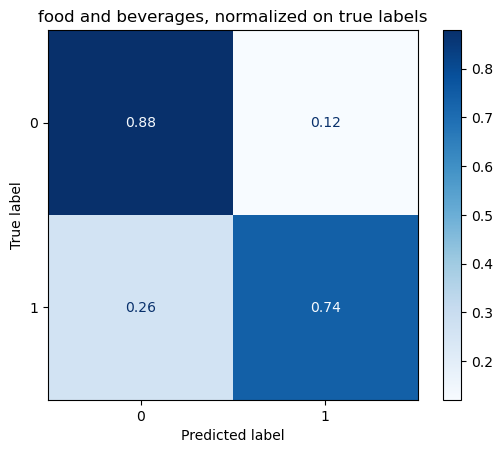

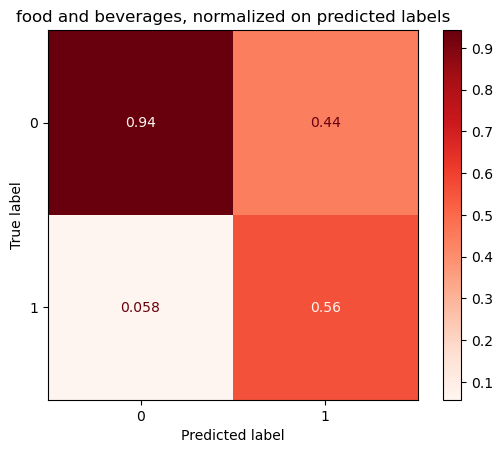

In [30]:
aspect = 'food and beverages'
dict_result = compute_prediction(BertForSequenceClassificationWithMoreLayers, "C:/Users/jadea/Notebooks/Mémoire M2 notebooks/model2.pth", aspect, AE_pred_label_control, probability=True)
threshold = 0.49
_, df_calc_scores = evaluate_sentiment_classification_nn2(full_test_set_2, aspect, dict_result, pred_sentences_link_reviews_control, skytrax_labels=True, probability = True, threshold=threshold)#,real_labels=real_labels_bipolar

##### For VADER:

In [ ]:
aspect = 'food and beverages' #adapt
testing_sentences = []
testing_labels = []
for key, value in AE_pred_label_control[aspect].items():
    testing_sentences.append(key)
    testing_labels.append(value)

In [ ]:
vader_result = analyze_list_of_sentences_vader(testing_sentences)
vader_result

In [ ]:
dict_result = compute_prediction(BertForSequenceClassificationWithMoreLayers, "C:/Users/jadea/Notebooks/Mémoire M2 notebooks/model2.pth", aspect, AE_pred_label_control, probability=True)
#choose threshold
threshold = 0.239
_, df_calc_scores = evaluate_sentiment_classification_vader(full_test_set_2, aspect, vader_result, pred_sentences_link_reviews_control, skytrax_labels = True, real_labels=None, threshold=threshold)

##### For VADER and supervised, run:

In [25]:
df_calc_scores

,Index,crew flight,proba_1,pred
0,17339,0,0.113774,0
1,29864,0,0.074936,0
2,19582,1,0.706719,1
3,30853,0,0.705949,1
4,19245,1,0.941261,1
...,...,...,...,...
840,97549,0,0.151831,0
841,99270,0,0.095971,0
842,21042,0,0.419845,0
843,99669,1,0.706894,1


To create result table for all aspects, iterate the code above on all aspects and run the code below after each iteration:

In [26]:
df_airline = pd.DataFrame()
for aspect in ['crew flight', 'food and beverages']:
    df_airline[aspect]=0
df_airline

,crew flight,food and beverages


In [31]:
#aspect = 'crew flight'
df_airline.at['predicted satisfaction', aspect] = df_calc_scores.mean(axis=0)['pred']
df_airline.at['real satisfaction', aspect] = df_calc_scores.mean(axis=0)[aspect]
df_airline.at['real insatisfaction', aspect] = 1-df_calc_scores.mean(axis=0)[aspect]
df_airline.at['predicted insatisfaction', aspect] = 1-df_calc_scores.mean(axis=0)['pred']
df_airline

,crew flight,food and beverages
predicted satisfaction,0.240237,0.226766
real satisfaction,0.234320,0.171004
real insatisfaction,0.765680,0.828996
predicted insatisfaction,0.759763,0.773234


#### Plot Histogram

##### Supervised models

C:\Users\jadea\AppData\Roaming\Python\Python311\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\jadea\AppData\Roaming\Python\Python311\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\jadea\AppData\Roaming\Python\Python311\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\jadea\A

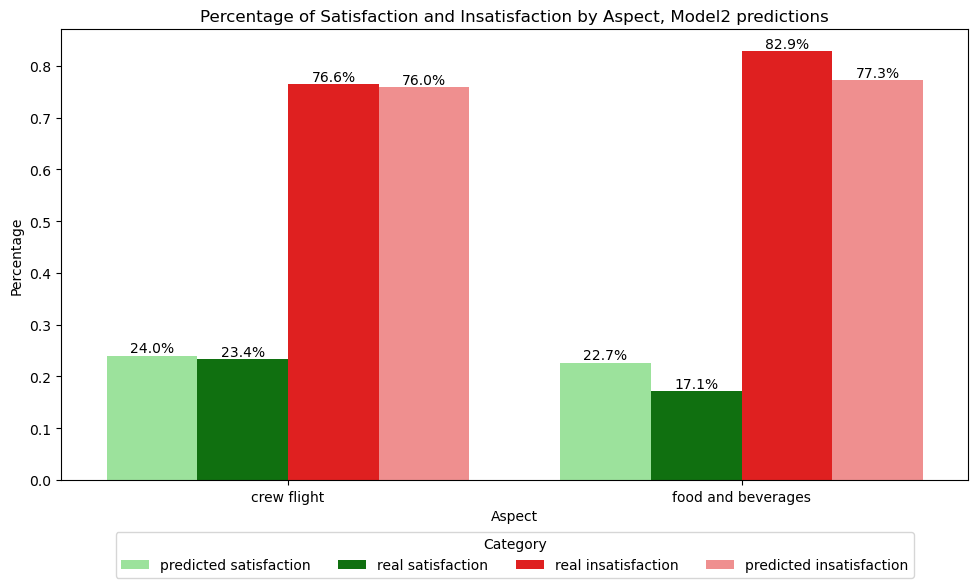

In [33]:
df = df_airline.copy()

# Melt the DataFrame for plotting
df_melted = pd.melt(df, id_vars=['category'], var_name='aspect', value_name='value')

# Define a custom color palette
palette = {
    'predicted satisfaction': '#90EE90',  # Light Green
    'real satisfaction': '#008000',       # Green
    'real insatisfaction': '#FF0000',     # Red
    'predicted insatisfaction': '#FF7F7F' # Light Coral
}

# Create the barplot
plt.figure(figsize=(10, 6))  # Adjust figure size as necessary
ax = sns.barplot(data=df_melted, x='aspect', y='value', hue='category', palette=palette)

# Add labels to the bars
for p in ax.patches:
    height = p.get_height()
    label = f'{height * 100:.1f}%'  # Scale by 100 to convert to percentage and format
    if height > 0.05:  # Adjust threshold if needed
        ax.text(p.get_x() + p.get_width() / 2., height, label, ha="center", va='bottom')

# Enhance plot aesthetics
plt.title('Percentage of Satisfaction and Insatisfaction by Aspect, Model2 predictions')
plt.xlabel('Aspect')
plt.ylabel('Percentage')

# Adjust legend placement to outside and below the chart
plt.legend(title='Category', loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4)

plt.tight_layout()  # Adjust the layout to make room for the legend
plt.show()


#### VADER

C:\Users\jadea\AppData\Roaming\Python\Python311\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\jadea\AppData\Roaming\Python\Python311\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\jadea\AppData\Roaming\Python\Python311\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\jadea\A

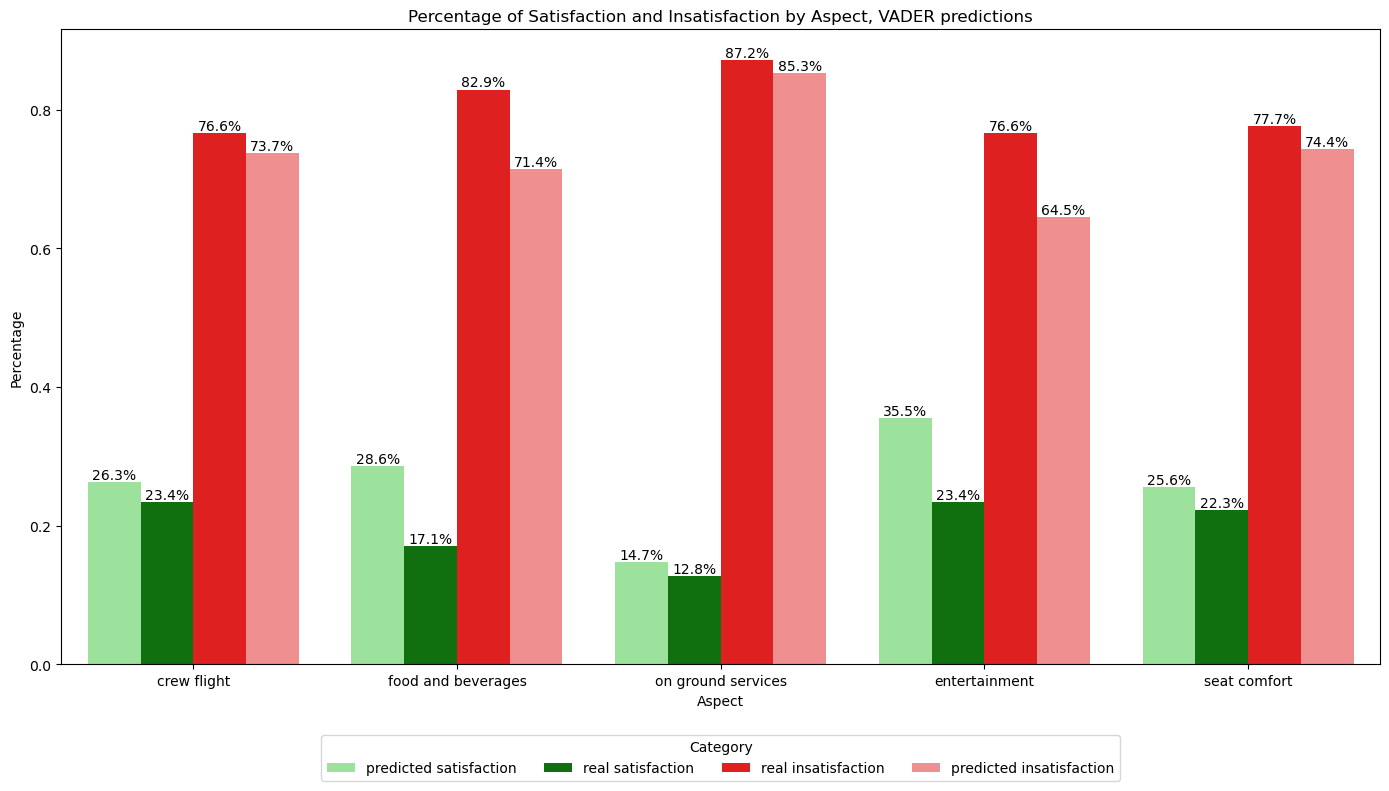

In [35]:
df = df_airline.copy()

# Melt the DataFrame for plotting
df_melted = pd.melt(df, id_vars=['category'], var_name='aspect', value_name='value')

# Define a custom color palette
palette = {
    'predicted satisfaction': '#90EE90',  # Light Green
    'real satisfaction': '#008000',       # Green
    'real insatisfaction': '#FF0000',     # Red
    'predicted insatisfaction': '#FF7F7F' # Light Coral
}

# Create the barplot
plt.figure(figsize=(14, 8))  # Increased figure size
ax = sns.barplot(data=df_melted, x='aspect', y='value', hue='category', palette=palette)

# Add labels to the bars
for p in ax.patches:
    height = p.get_height()
    label = f'{height * 100:.1f}%'  # Scale by 100 to convert to percentage and format
    if height > 0.05:  # Adjust threshold if needed
        ax.text(p.get_x() + p.get_width() / 2., height, label, ha="center", va='bottom')

# Enhance plot aesthetics
plt.title('Percentage of Satisfaction and Insatisfaction by Aspect, VADER predictions')
plt.xlabel('Aspect')
plt.ylabel('Percentage')

# Adjust legend placement to outside and below the chart
plt.legend(title='Category', loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4)

plt.tight_layout()  # Adjust the layout to make room for the legend
plt.show()
